## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [137]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [4]:
train_data.shape

(84534, 10)

__First Step is to check invariant metric - no. of participants in control vs experiment(those who received promotional offer vs those who did not)__

Hypothesis:

$$H_{0}: Exp_{participants} - Control_{participants} = 0      
$$$$H_{a}: Exp_{participants} - Control_{participants} > 0  
$$$$\alpha = 0.05$$

In [5]:
print("The number who received the promotion: {} and the number who did not: {}.".format((train_data.Promotion == "Yes").sum(),(train_data.Promotion == "No").sum()))

The number who received the promotion: 42364 and the number who did not: 42170.


In [6]:
#Statistic for different in group sizes

Promotion_avg = ((train_data.Promotion == "Yes").sum())/train_data.shape[0]
Non_Promotion_avg = (train_data.Promotion == "No").sum()/train_data.shape[0]
sample_difference = Promotion_avg - Non_Promotion_avg
print("Promotion average : {}." .format(Promotion_avg))
print("Non Promotion average : {}." .format(Non_Promotion_avg))
print("Sample Difference : {}." .format(sample_difference))

Promotion average : 0.5011474672912675.
Non Promotion average : 0.4988525327087326.
Sample Difference : 0.00229493458253488.


In [7]:
#Bootstrapping for differences

differences = []
for _ in range(10000):
    bootsamp = train_data.sample(30000, replace=True)
    Promotion_avg = ((bootsamp.Promotion == "Yes").sum())/bootsamp.shape[0]
    Non_Promotion_avg = (bootsamp.Promotion == "No").sum()/bootsamp.shape[0]
    differences.append(Promotion_avg - Non_Promotion_avg)

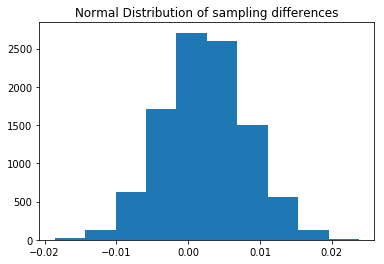

In [8]:
#Plotting histogram of the distribution

plt.hist(differences)
plt.title('Normal Distribution of sampling differences');

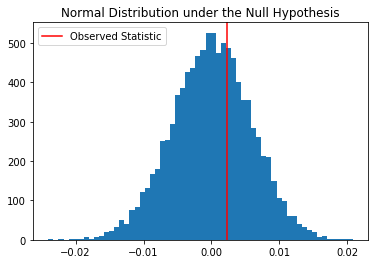

In [9]:
#Null hypothesis distribution

null_vals = np.random.normal(0, np.std(differences), 10000)
plt.hist(null_vals, bins=60)
plt.axvline(sample_difference, color='r', label ="Observed Statistic")
plt.legend(loc='upper left')
plt.title("Normal Distribution under the Null Hypothesis");

In [10]:
# Significance of our result

p_val = (sample_difference>null_vals).mean()
p_val

0.64670000000000005

P Value is within the confidence interval, __we fail to reject null hypothesis__ indicates, no statistical significance in the difference of our sampling values

__Lets have a look at Net Incremental Revenue (NIR) effect__  

$$H_{0}:Net Incremental Revenue = 0\
$$$$H_{a}:Net Incremental Revenue > 0\
$$$$\alpha = 0.05$$

Our Alpha value with the Bonferroni Correction:$$Bonferroni Correction = \frac{\alpha}{number-of-measures} = 0.025$$

Where:

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [11]:
# Calculating NIR
#purch = purchasem cust = customer

purch_treatment = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
cust_treatment = train_data[train_data['Promotion'] == "Yes"].shape[0]
purch_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
NIR = (10*purch_treatment - 0.15*cust_treatment)-10*purch_control
NIR

-2334.5999999999995

In [12]:
# Bootstrapping to get model of distribution for null

NIRs = []
for _ in range(10000):
    bootsample = train_data.sample(30000, replace=True)
    purch_treatment = bootsample[bootsample['Promotion'] == "Yes"].purchase.sum()
    cust_treatment = bootsample[bootsample['Promotion'] == "Yes"].shape[0]
    purch_control = bootsample[bootsample['Promotion'] == "No"].purchase.sum()
    NIRs.append((10*purch_treatment - 0.15*cust_treatment)-10*purch_control)

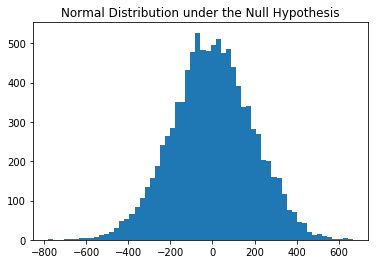

In [13]:
# Distribution

null_NIRs = np.random.normal(0, np.std(NIRs), 10000)
plt.hist(null_NIRs, bins=60)
plt.title("Normal Distribution under the Null Hypothesis");

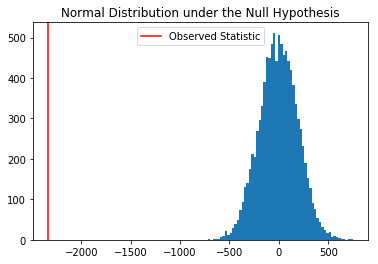

In [14]:
# Normal distribution under Null

plt.axvline(NIR, color='r', label ="Observed Statistic")
null_NIRs = np.random.normal(0, np.std(NIRs), 10000)
plt.hist(null_NIRs, bins=60)
plt.title("Normal Distribution under the Null Hypothesis")
plt.legend();

In [15]:
# Checking P value

pval = (NIR>null_NIRs).mean()
pval

0.0

P Value is well within the confidence interval & hence __We fail to reject Null Hypothesis__  
There is no statistically signifcant increase in NIR (Metric that we wanted to optimize)

Let's take a look at effect on __Incremental Response Rate (IRR)__

Below we shall determine if the experiment had a positive effect on the IIR metric.  

Hypothesis:  

$$H_{0}:Incremental Response Rate = 0  
$$$$H_{a}:Incremental Response Rate > 0   
$$$$\alpha = 0.025$$

Where:$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [16]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [17]:
#Calculating observed statistic

purch_treatment = train_data[train_data['Promotion'] == "Yes"].purchase.sum()
cust_treatment = train_data[train_data['Promotion'] == "Yes"].shape[0]
purch_control = train_data[train_data['Promotion'] == "No"].purchase.sum()
cust_control = train_data[train_data['Promotion'] == "No"].shape[0]
IRR = purch_treatment/cust_treatment - purch_control/cust_control
IRR

0.0094545478197727018

In [18]:
# Bootstrapping to get model of distribution for Null hypothesis

IRRs = []
for _ in range(10000):
    bootsample2 = train_data.sample(30000, replace=True)
    purch_treatment = bootsample2[bootsample2['Promotion'] == "Yes"].purchase.sum()
    cust_treatment = bootsample2[bootsample2['Promotion'] == "Yes"].shape[0]
    purch_control = bootsample2[bootsample2['Promotion'] == "No"].purchase.sum()
    cust_control = bootsample2[bootsample2['Promotion'] == "No"].shape[0]
    IRR_boot = purch_treatment/cust_treatment - purch_control/cust_control
    IRRs.append(IRR_boot)

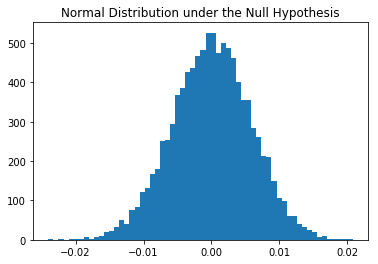

In [19]:
#Null Hypothesis distribution

null_IRRs = np.random.normal(0, np.std(IRRs), 10000)
plt.hist(null_vals, bins=60)
plt.title("Normal Distribution under the Null Hypothesis");

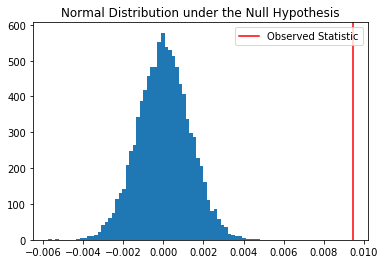

In [20]:
# Observed statistic versus bootstrapping sample

plt.axvline(IRR, color='r', label ="Observed Statistic")
null_IRRs = np.random.normal(0, np.std(IRRs), 10000)
plt.hist(null_IRRs, bins=60)
plt.title("Normal Distribution under the Null Hypothesis")
plt.legend();

In [21]:
# P Value of IRR

pval_IRR = (IRR>null_IRRs).mean()
pval_IRR

1.0

P value of IRR is above the null distribution, hence __We reject Null hypothesis__  
This indicates there is significant increase statistically in IRR between Control & Experimental groups.  
__Our Campaign has a positive effect on the # of customers who purchased product with promotion__ as compared to those who dint receive promotion

__Modeling__

In [22]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [23]:
train_data.shape

(84534, 10)

In [28]:
# No. of customers purchasing both in control & experimental group

train_data.groupby('Promotion').purchase.sum()

Promotion
No     319
Yes    721
Name: purchase, dtype: int64

In [29]:
# Copy DataFrame, Using Experiment group for modeling, dropping columns not necessary

data_exp = train_data.copy()
data_exp = data_exp[data_exp['Promotion']=="Yes"]
data_exp.drop(['ID','Promotion'], axis = 1, inplace=True)

In [30]:
# Shape

data_exp.shape

(42364, 8)

In [31]:
data_exp.head()

,purchase,V1,V2,V3,V4,V5,V6,V7
4,0,3,28.044332,-0.385883,1,1,2,2
8,0,2,31.930423,0.393317,2,3,1,2
10,0,1,32.770916,-1.511395,2,1,4,1
12,0,1,36.957009,0.133583,2,3,1,1
14,0,3,36.911714,-0.905350,2,2,4,1


In [32]:
# Splitting data

X = data_exp.drop(['purchase'],axis=1)
y = data_exp.purchase

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [138]:
# Fit Model

rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced')
rfc.fit(X,y)



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [121]:
# Test data

test_data = pd.read_csv('./Test.csv')
test_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [122]:
# Test data for model

data_exp_test = train_data.copy()
data_exp_test = data_exp_test[data_exp_test['Promotion']=="Yes"]
data_exp_test.drop(['ID','Promotion'], axis = 1, inplace=True)
X_test = data_exp_test.drop(['purchase'],axis=1)
y_test = data_exp_test.purchase

In [123]:
X_test = min_max_scaler.fit_transform(X_test)

In [139]:
# Predict

y_pred = rfc.predict(X_test)

In [140]:
#Model Accuracy

accuracy = (y_pred == y_test).mean()
print("Our accuracy for the random forest model was {0:.5f}%".format(accuracy))

Our accuracy for the random forest model was 0.98298%


In [141]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rfc_cv_score = cross_val_score(rfc, X, y, cv=cv, scoring='roc_auc')

In [142]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[41643     0]
 [  721     0]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.98      1.00      0.99     41643
          1       0.00      0.00      0.00       721

avg / total       0.97      0.98      0.97     42364



=== All AUC Scores ===
[ 0.51123189  0.50163065  0.48549753  0.54516891  0.54802407  0.55145126
  0.48358116  0.54814248  0.50908748  0.50696279  0.50045552  0.53322996
  0.52077831  0.50735304  0.50788171  0.49248853  0.51785142  0.50132418
  0.50339217  0.52683718  0.51344373  0.50401494  0.50520875  0.51425079
  0.51508632  0.49804375  0.52429221  0.53288938  0.4940095   0.52940048]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.514433670148


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [143]:
# Converting 0/1 to No/Yes

promotion_y_n = []
for value in y_pred:
    if value == 0:
        promotion_y_n.append("No")
    if value == 1:
        promotion_y_n.append("Yes")

In [144]:
np.asarray(promotion_y_n)

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], 
      dtype='<U2')

In [145]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    min_max_scaler = preprocessing.MinMaxScaler()
    df = min_max_scaler.fit_transform(df)
    
    y_pred = clf.predict(df)
    
    promotion_y_n = []
    for value in y_pred:
        if value == 0:
            promotion_y_n.append("No")
        if value == 1:
            promotion_y_n.append("Yes")
            
    promotion = np.asarray(promotion_y_n)
    
    
    
    return promotion

In [146]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is nan.

Your nir with this strategy is 0.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/home/workspace/test_results.py:9: RuntimeWarning: invalid value encountered in long_scalars
  irr = n_treat_purch / n_treat - n_ctrl_purch / n_control


(nan, 0.0)

From the above results, __we got better IRR but significantly worse NIR__  
The Confusion Matrix indicates we had small number of false negatives.  

